# Compare Several Models

## Import packages

In [1]:
from warnings import simplefilter, filterwarnings
simplefilter('ignore')
filterwarnings('ignore')

## Data Preparation

<Axes: >

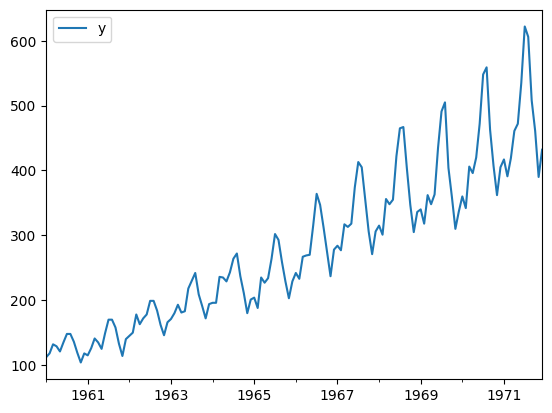

In [2]:
import pandas as pd
from sktime.datasets import load_airline
data = load_airline().rename('y').to_frame()
data.index = pd.date_range(start='1960-01-01', periods=len(data), freq='M')
data.plot()

## Section1: Difinir la liste des modeles a comparer

### Option 1 : List of Models from a LiquidityForecast Object List
Default choice if you have already estimated models and wish to compare them without re-estimating.
```python
import pickle
from forecast_combine.model_select import ForecastModelSelect

forecasters_paths_d = {'forecaster1': 'forecaster1.pkl',
                       'forecaster2': 'forecaster2.pkl',
                       'forecaster3': 'forecaster3.pkl'}
trained_forecasters_d= {}
for forecaster_name, file in forecasters_paths_d.items():
    with open(f, 'rb') as file:
        trained_forecasters_d[forecaster_name] = pickle.load(file)
    

model = ForecastModelSelect(
            data= data,
            depvar_str = 'y',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            trained_forecasters_d = ,
            freq = 'M',
            mode = 'best_horizon',
            score = 'RMSE', 
            )
```

### Option 2: List of Models from a dictionary
Default choice if you want to reestimate the models

In [3]:
# models necessary to define the forecasting models 
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS
)

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "AutoARIMA": StatsForecastAutoARIMA(),
    "AutoETS": StatsForecastAutoETS(),
    "AutoTheta": StatsForecastAutoTheta(),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=1),
}

In [4]:
from forecast_combine.model_select import ForecastModelSelect
model = ForecastModelSelect(
            data= data,
            depvar_str = 'y',                 
            exog_l=None,
            fh = 5,
            pct_initial_window=0.75,
            step_length = 1,
            forecasters_d = ForecastingModels,
            freq = 'M',
            mode = 'best_horizon',
            score = 'RMSE', 
            )

Importing plotly failed. Interactive plots will not work.


## Section 2: Evaluate the model OOS

In [5]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/fore

Evaluation completed in: 0.027 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/fore

Evaluation completed in: 0.202 minutes

Start AutoETS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/fore

Evaluation completed in: 0.317 minutes

Start AutoTheta forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/fore

Evaluation completed in: 0.326 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated

Evaluation completed in: 0.451 minutes


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:415: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/ubuntu/Documents/Projects/fore

In [6]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoARIMA,32,10.003256,0.914194,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,69.067977,59.085087,0.129053,-1.332635,50.433408
AutoTBATS,32,23.319156,0.005045,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,81.682585,71.700665,0.163132,-3.128296,66.405879
AutoTheta,32,18.396102,0.211365,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,87.698958,76.762472,0.176846,-3.950984,71.269807
Naive,32,0.002134,0.013173,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,88.977211,77.76875,0.177787,-3.805336,71.78125
AutoETS,32,17.743402,0.381538,108,139,1968-12-31 00:00:00,1971-07-31 00:00:00,87.615217,76.912179,0.17867,-4.137762,71.34656


horizon                     1          2           3           4           5
Naive     RMSE      47.586763  79.790742  100.825499  115.377505  120.035802
          MAE       39.562500  65.875000   81.781250   97.718750  103.906250
          MAPE       0.092685   0.149424    0.187223    0.224854    0.234746
          R2         0.656898   0.028086   -0.651203   -1.199906   -1.484603
          MedianAE  35.000000  70.000000   68.000000   75.000000  104.500000
AutoARIMA RMSE      41.505074  70.887687   82.659801   89.513209   88.926434
          MAE       35.606330  58.391263   61.213751   69.476249   70.737842
          MAPE       0.084212   0.128316    0.130832    0.150625    0.151279
          R2         0.738993   0.232878   -0.109810   -0.324147   -0.363632
          MedianAE  33.655864  50.496771   45.137837   54.944429   54.396800
AutoETS   RMSE      47.233580  79.126769  100.143594  115.336261  120.693672
          MAE       38.927143  64.980968   80.118497   96.418261  104.116028
          MAPE       0.091895   0.149039    0.185715    0.226217    0.240482
          R2         0.661972   0.044194   -0.628944   -1.198334   -1.511912
          MedianAE  34.029840  61.799517   67.546792   91.790439   93.941278
AutoTheta RMSE      47.455782  79.402778  100.242073  114.928972  119.611609
          MAE       39.194461  65.127944   80.225287   96.313382  102.951287
          MAPE       0.092133   0.148530    0.184583    0.223712    0.235269
          R2         0.658785   0.037514   -0.632149   -1.182835   -1.467074
          MedianAE  34.085312  65.776215   66.928436   84.442123   96.105377
AutoTBATS RMSE      45.966873  78.201237   93.731598  103.760189  103.368975
          MAE       40.047248  68.223678   77.063454   87.032553   86.136395
          MAPE       0.095470   0.155854    0.175129    0.197932    0.191275
          R2         0.679860   0.066423   -0.427026   -0.779194   -0.842536
          MedianAE  36.799842  69.674677   65.960437   74.015789   76.023251

## Section 3: Select the best model

In [7]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5
Best_1,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA
Best_2,AutoETS,AutoTheta,AutoTBATS,AutoTBATS,AutoTBATS
Best_3,AutoTheta,AutoETS,AutoTheta,AutoTheta,Naive
Best_4,Naive,Naive,AutoETS,Naive,AutoTheta
Best_5,AutoTBATS,AutoTBATS,Naive,AutoETS,AutoETS


,Naive,AutoARIMA,AutoETS,AutoTheta,AutoTBATS,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,
1,0.092685,0.084212,0.091895,0.092133,0.095470,0.084212,0.084212,0.089841,0.088053,0.091279
2,0.149424,0.128316,0.149039,0.148530,0.155854,0.128316,0.128316,0.142085,0.138423,0.146233
3,0.187223,0.130832,0.185715,0.184583,0.175129,0.130832,0.130832,0.152981,0.152981,0.172697
4,0.224854,0.150625,0.226217,0.223712,0.197932,0.150625,0.150625,0.174279,0.174279,0.204668
5,0.234746,0.151279,0.240482,0.235269,0.191275,0.151279,0.151279,0.171277,0.171277,0.210610


<Axes: title={'center': 'Out of Sample Performance'}, xlabel='horizon', ylabel='MAPE'>

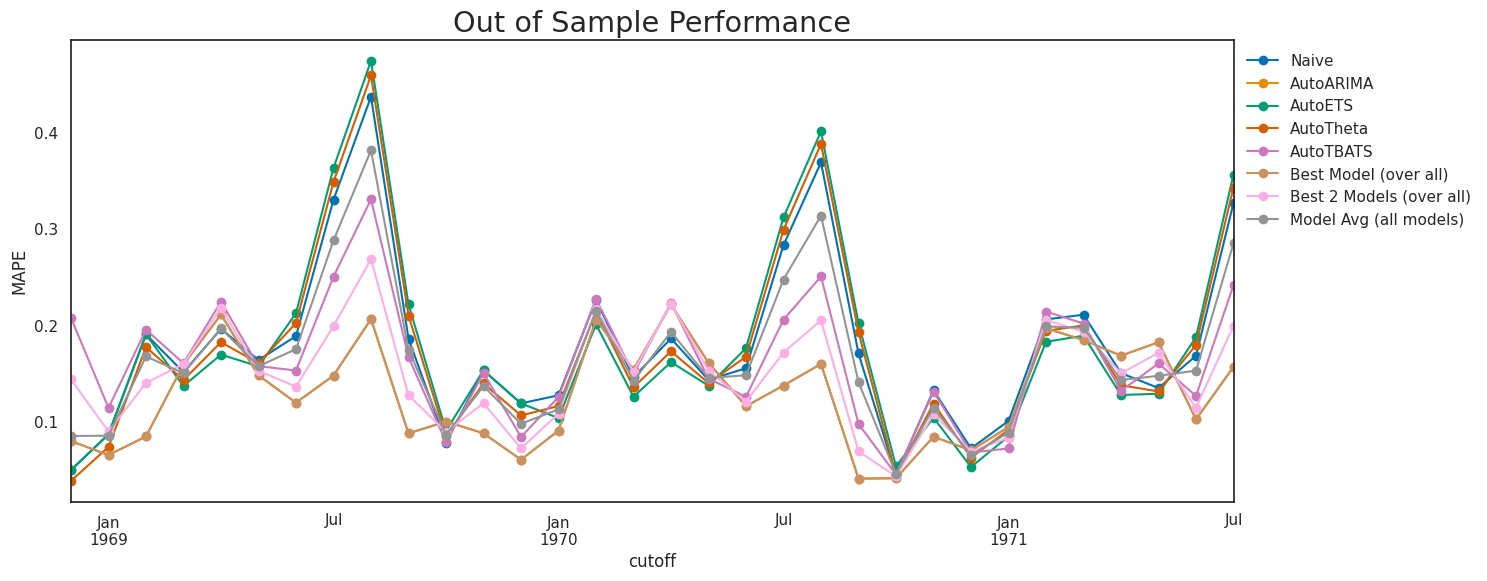

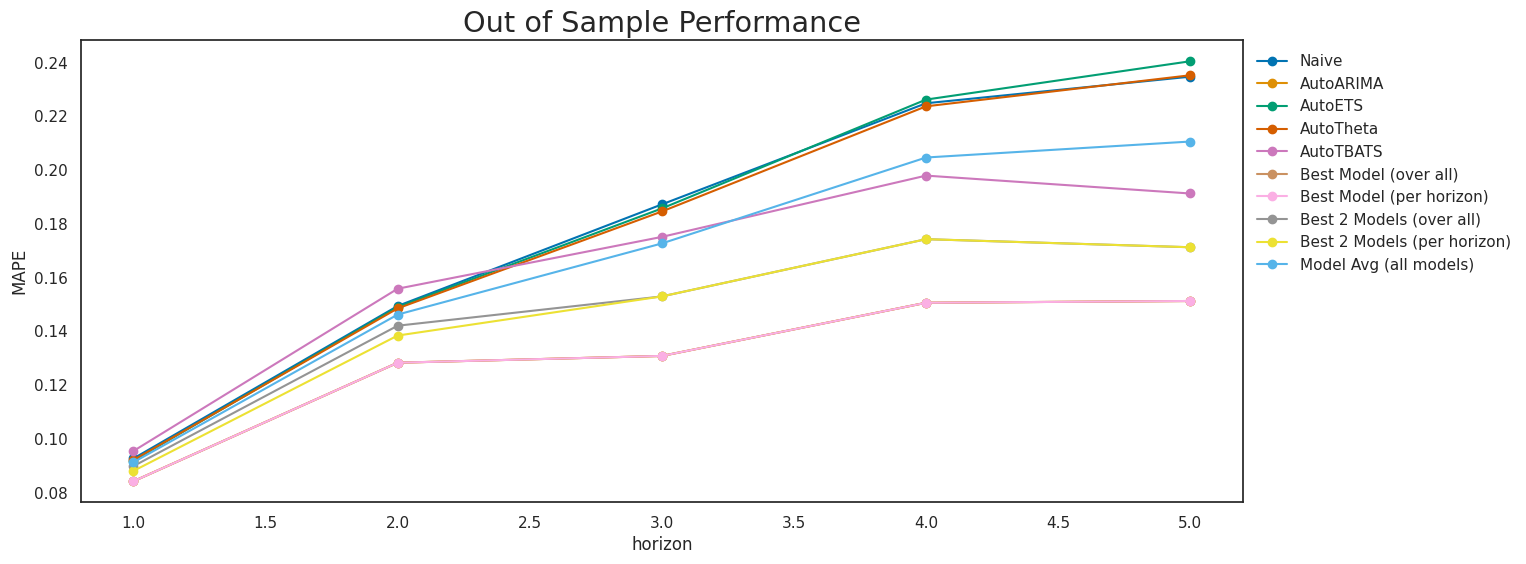

In [8]:
model.plot_model_compare(score ='MAPE', view = 'cutoff')
model.plot_model_compare(score ='MAPE', view = 'horizon')

## Section 4 : Generate Predictions
The prediction aggregate the single models predictions is several ways:
* 'best': The prediction is based on the best model.
* 'best_horizon': The prediction is based on the best model for each horizon.
* 'average': The average of the prediction of all models.
* 'inverse_score': The weighted average prediction, where weights are inversely proportional to the model performance score.
* 'nbest_average': Average of the n best models. The n is given by the parameter nbest.
* 'nbest_average_horizon': Average of the n best models for each horizon. The n is given by the parameter nbest.

(<Figure size 1500x600 with 1 Axes>, <Axes: title={'center': 'Prediction'}>)

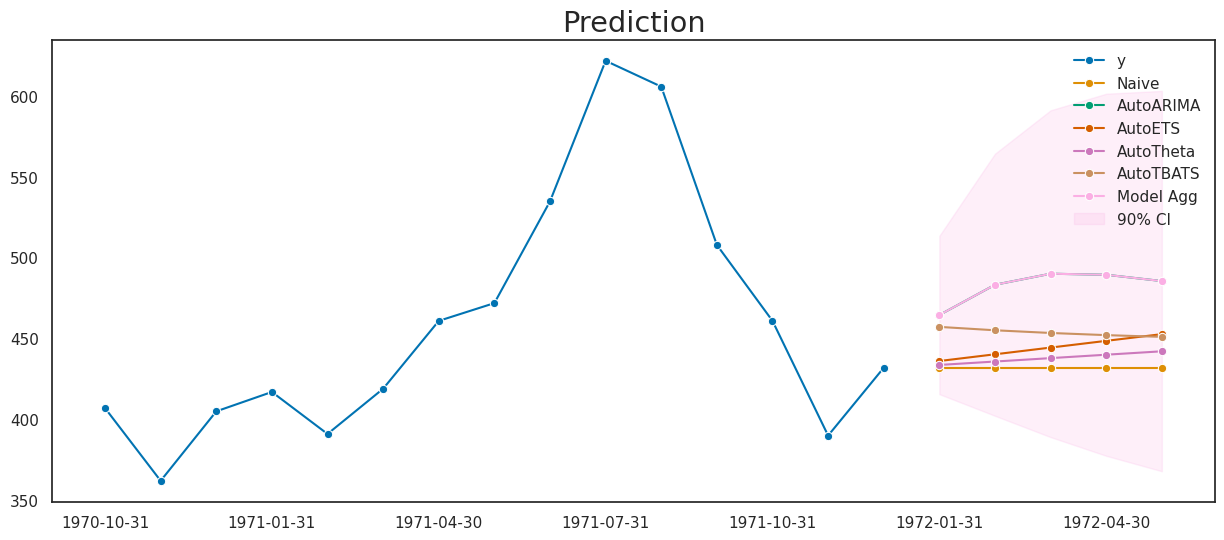

In [9]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='best_horizon', ret_underlying=True)
model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)  

## Section 5: Update data and regenerate the model

In [10]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()

<Axes: title={'center': 'Prediction'}>

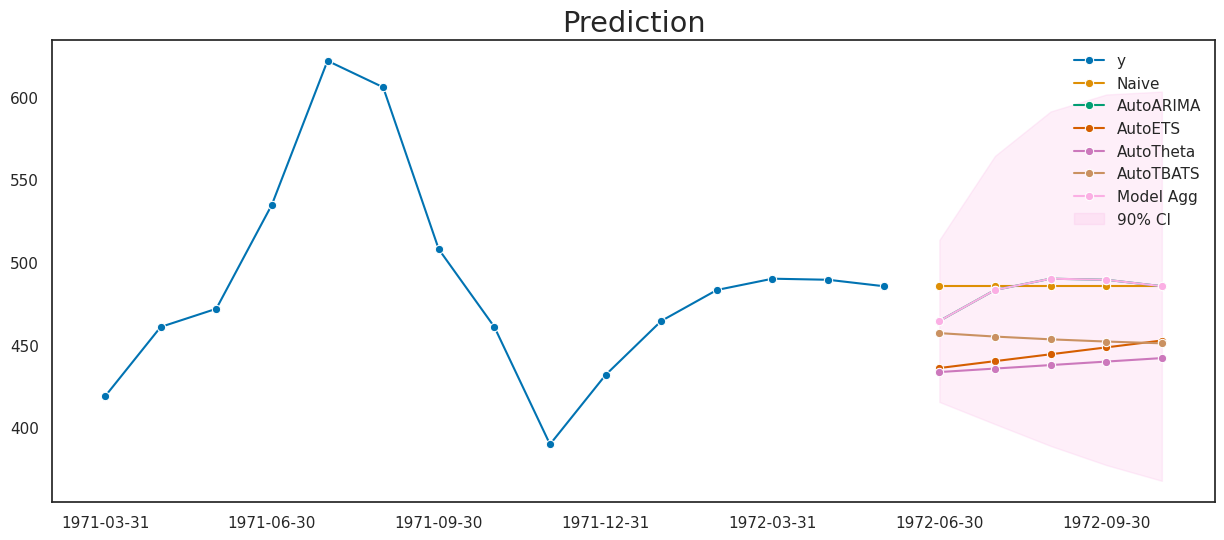

In [11]:
new_y = pd.concat([data.squeeze(),y_pred], axis=0)
y_pred, y_pred_ints, preds, pred_ints = model.update(new_y=new_y, mode='best', 
                                                     ret_underlying=True)
f, ax = model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)    
ax

In [12]:
model.get_pred_errors()

,cutoff,horizon,error
0,1968-12-31,1,-20.150388
1,1969-01-31,1,-29.116752
2,1969-02-28,1,15.908002
3,1969-03-31,1,-26.683214
4,1969-04-30,1,29.195934
...,...,...,...
155,1971-03-31,5,178.299790
156,1971-04-30,5,73.152112
157,1971-05-31,5,29.029369
158,1971-06-30,5,-77.393773
